# IMPORTANT NOTE

This version of the code is for me (Nicholas) to meddle with, testing fixes and generating arguments for why we should observe certain targets. This is perhaps a template for things you can do with the tutorial, but is a much messier file, so beware

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy as ap
from scipy.stats import binned_statistic_dd
from scipy.stats import linregress

# Atmospheric Prioritization

The goal of this code is to find planets which are good candidates for atmospheric follow-up. We are particularly interested in planets which are from poorly-covered regions of parameter space (e.g., smaller than previously-known planets, or around different types of star, or with more/less irradiation). Because the code was developed for TESS planets, we impose a cutoff at 11.2 R_e. If you change that, beware of the breakdown of the empirical mass-radius relationship for larger planets; you will need to implement a statistical model, e.g. mr_forecaster by Chen & Kipping 2017. 

In [2]:
from priority_tools import *

# Loading the Necessary Data

The first thing to do is get all the data set up. You need to load in the toi+ list (data/toi/toi+-...), where ... is the date of the most recent data release. If you are curious about previous releases, some of them are also in that directory. You also need the TIC star info, which has V, J, and K magnitudes that are missing from TOI+. 

In [3]:
#generate the key names for all the TOI+ columns we need
rp_key,ms_key,pp_key,Ts_key,ars_key,Jmag_key,\
    Vmag_key,rs_key,dec_key,Fp_key,mp_key,\
    mp_units,id_key = tess_colnames()

#where are the files?
toiplus_loc = 'data/toi/toi+-2020-01-30.csv'
TICinfo_loc = 'data/exofop/TIC_star_info_2020-01-30.csv'

#load the TOI+ list
toiplus = pd.read_csv(toiplus_loc,
                      delimiter=',',header=4)

#load the TIC star info
TIC_info = pd.read_csv(TICinfo_loc,
                       delimiter=',',header=10)

#run the data cleaning function 
tess = clean_tess_data(toiplus, TIC_info, include_qlp=False)

#load the known planets (and Kepler PCs) table, and merge it
kps = pd.read_csv(r'data/kp-k14_pc-v14.csv')
d = tess.append(kps[np.logical_and(kps['K_amp'] > 1.5, 
                                   kps['TSM'] > 10)],sort=False) 
    #the K_amp cut wasn't made in the data itself, but is 
    #necessary to cut some of those not-real long-period
    #KOIs as well as known planets for which we can't get masses
    
    #The TSM cut is also made to exclude dubious Kepler planets 
    #(i.e., way too low Rp/Rs on a dim star for atmospheres, or
    #orbiting way too far away from their host)

In [4]:
tess[tess[id_key]==455.01]

,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,...,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM
65,spoc,98796344,455.01,45.4642,-16.5934,8.64,0.018,1412.708786,0.00091,5.358807,...,30.046283,2.245208,98796344,45.462478,-16.594496,10.59,7.294,6.774,6.496,43.269585


# Binning

With all the data loaded, we can run the binning function and generate the pandas dataframe object that we can use for the rest of the analysis. 

In [5]:
#defining the bins: log-uniform in radius and Fp, 
#uniform in Teff. Right now, you need 6 bin edges
#for radius and Fp and 4 for Teff; we can change
#that by editing the "labels" in binning_function
rad_bins = 10**(np.linspace(0,1,6)) 
#rad_bins[0] = 0.7 #to catch any small planets a search from 1 Rp might have missed
rad_bins[-1] = 11.2
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
bins = [rad_bins, fpl_bins, tef_bins]

b = binning_function(d, bins) #b stands for "binned", 
                            #to make use easier

# Playing With The Data

Now, we can start looking at the data! Two very simple things we might want to do are look at a single TOI, and look at it in the context of its bin. If you've used pandas before, messing around with these data will be straightforward; if not, here are some useful tricks. To load a single object, use: b[b[id_key] == x], where x is the ID number including .01 or .02 (or .03, or whichever planet you want if it's a highly multiple system)

In [6]:
#make sure we can see the columns in the middle of the output
pd.options.display.max_columns = 100 

#call the request
b[b[id_key] == 256.02]

#the output tells us the radius, insolation, and Teff bins, as
#well as all the data from the TOI plus list and values that
#we've calculated

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2,1,spoc,92226327.0,256.02,11.247108,-15.271294,11.238,0.07,1389.293276,0.002136,3.778378,0.000784,1.028338,0.2879,3334.77603,300.73108,3,LHS-1140c,5.05701,0.0,2.0,0.19,0.0,1.136554,0.410558,379.011837,3131.0,0.0,4.876768,10.993546,False,2018-11-30 22:06:23+0000,2018-11-30 22:06:23+0000,0.150019,1.536701,28.557982,2.238591,92226327.0,11.248632,-15.274109,14.15,9.612001,9.092,8.821,24.907571,NaN,1,2,1,0.0


In [7]:
#you can also ask for a few specific columns if you want 
#a much less messy output; we'll call these uks for 
#"useful keys" for the future 

uks = [id_key,rp_key,pp_key,Ts_key,Fp_key,'TSM','V mag','J mag','priority']
b[b[id_key] == 'K2-18 b'][uks]

,,,Full TOI ID,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,TSM,V mag,J mag,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,
2,2,1,K2-18 b,2.37,32.939623,3457.0,1.050929,35.203684,13.496,9.763,0.0


In [8]:
#look into this bin, and select only the top 5 (by TSM)
b.loc[3,3,3].head(5)

Source Pipeline          TIC Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                            
3          3         3                      spoc  269701147.0     1339.01   
                     3                      spoc   33692729.0      469.01   
                     3                      spoc  453211454.0      509.01   
                     3                      spoc  377064495.0      561.01   
                     3                      spoc  269701147.0     1339.02   

                                  TIC Right Ascension  TIC Declination  \
radius_bin insol_bin st_Teff_bin                                         
3          3         3                     302.023979        66.850576   
                     3                      93.058225       -14.650035   
                     3                     117.924970         9.386054   
                     3                     148.185590         6.216373   
                     3                     302.023979        66.850576   

                                  TMag Value  TMag Uncertainty  \
radius_bin insol_bin st_Teff_bin                                 
3          3         3                 8.293             0.006   
                     3                 8.719             0.019   
                     3                 7.905             0.018   
                     3                 9.495             0.017   
                     3                 8.293             0.006   

                                  Orbital Epoch Value  Orbital Epoch Error  \
radius_bin insol_bin st_Teff_bin                                             
3          3         3                    1715.354486             0.002530   
                     3                    1474.567411             0.001922   
                     3                    1494.445731             0.001498   
                     3                    1527.055259             0.006522   
                     3                    1726.054253             0.001723   

                                  Orbital Period Value  Orbital Period Error  \
radius_bin insol_bin st_Teff_bin                                               
3          3         3                        8.880832              0.000820   
                     3                       13.632935              0.002640   
                     3                       18.119809              0.002151   
                     3                       10.781327              0.009318   
                     3                       28.579356              0.002426   

                                  Transit Duration Value  \
radius_bin insol_bin st_Teff_bin                           
3          3         3                          3.019178   
                     3                          4.422229   
                     3                          3.669772   
                     3                          4.858829   
                     3                          4.444383   

                                  Transit Duration Error  Transit Depth Value  \
radius_bin insol_bin st_Teff_bin                                                
3          3         3                          0.156000          1213.388063   
                     3                          0.176513          1207.715363   
                     3                          0.189904           891.412821   
                     3                          0.398929          1207.247640   
                     3                          0.250002          1091.996125   

                                  Transit Depth Error            Sectors  \
radius_bin insol_bin st_Teff_bin                                           
3          3         3                      39.248430  14 15 16 17 18 19   
                     3                      56.476704                  6   
                     3                      42.654500                  7   
                     3            

# The Visualization Tool
Let's try the visualization tool, which displays all the high-priority objects in a given radius bin. Priority 1 is green, 2 is yellow, 3 is orange. Additionally, any planets with known transmission spectra are displayed in red (for those with observed features) or grey (for those with no observed features; note that, especially for confirmed TESS planets, observations might be very limited so "no observed features" doesn't necessarily mean cloudy). 

Dots scale linearly with planet radius. Labels indicate the object: floats are TOIs (i.e. "421.01" is TOI 421.01), anything starting with "K0" or "EPIC" is an unconfirmed KOI or K2 object, respectively, and everything else is a confirmed planet (including some previously-confirmed TOIs - for example TOI 270c falls into this category). Note that long-period KOIs (i.e., those in the top left - with relatively hot stars but earth-like insolation) are generally considered unreliable and should not automatically be assumed to actually exist or be good potential atmospheric targets. 

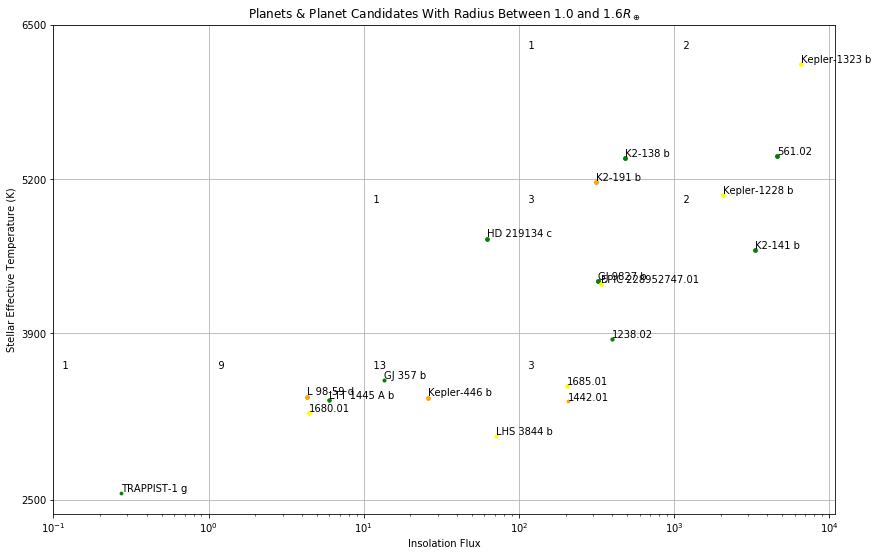

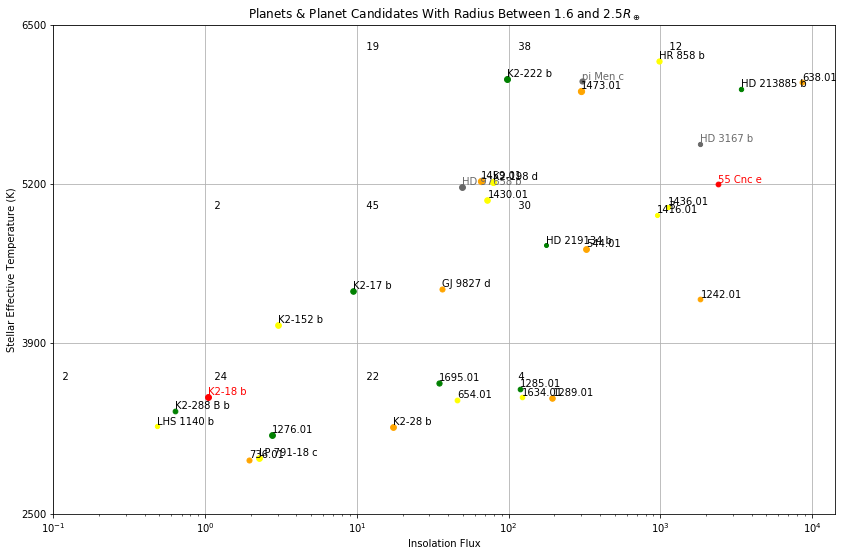

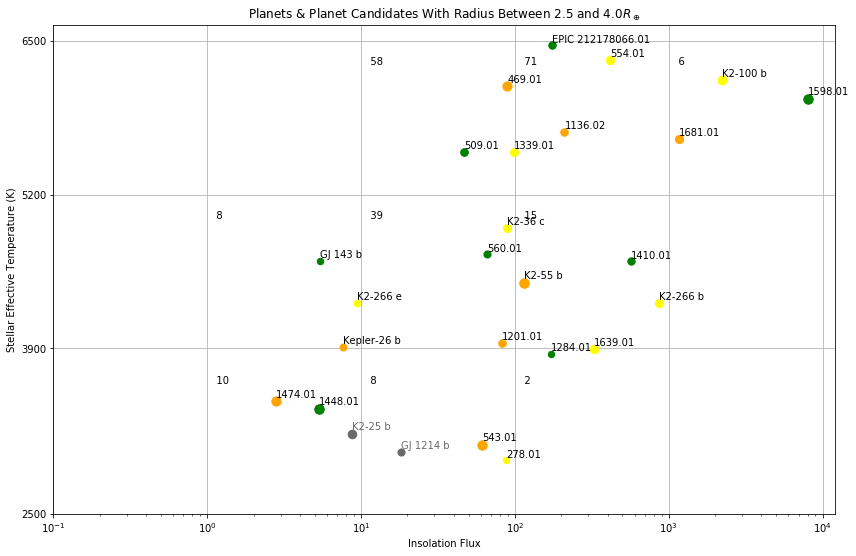

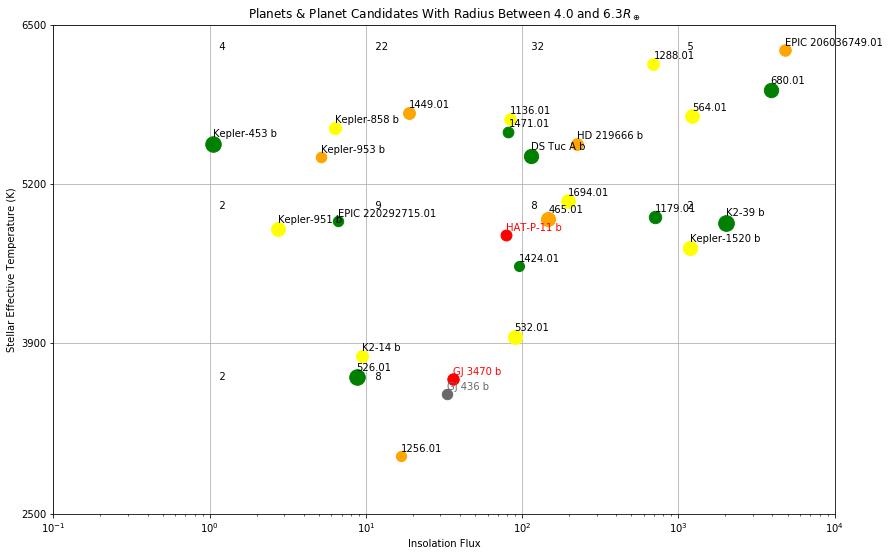

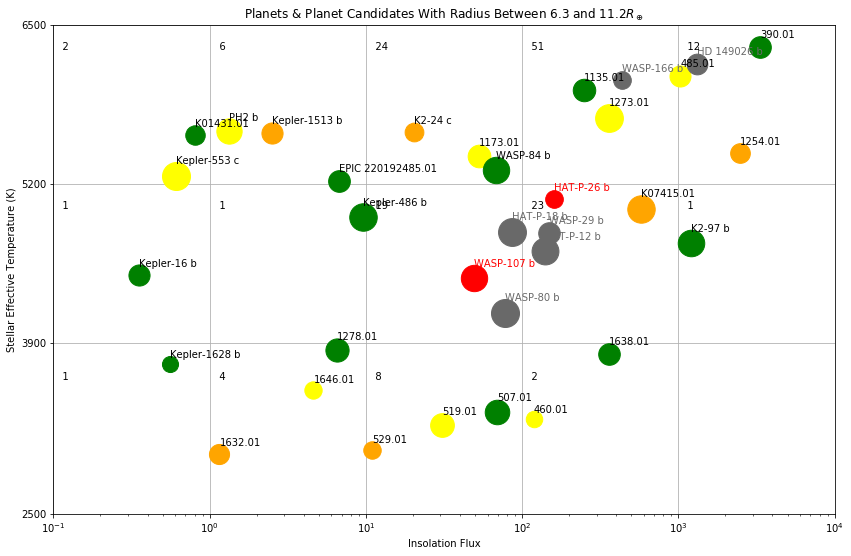

In [9]:
#bin_plotter inputs are the binned data, the bin edges
#(as defined above), and the radius bin of interest
for i in np.arange(1,6):
    bin_plotter(b,bins,i)

In [10]:
#all priorities
p1 = b[b['priority']==1].reset_index(drop=True)[id_key].values
p1tois = []
for obj in p1:
    if type(obj) == float:
        p1tois.append(obj)
p1tois.sort()
#p1tois

In [11]:
#all priorities
p2 = b[b['priority']==2].reset_index(drop=True)[id_key].values
p2tois = []
for obj in p2:
    if type(obj) == float:
        p2tois.append(obj)
p2tois.sort()
#p2tois

In [12]:
p3 = b[b['priority']==3].reset_index(drop=True)[id_key].values
p3tois = []
for obj in p3:
    if type(obj) == float:
        p3tois.append(obj)
p3tois.sort()
#p3tois

In [13]:
#for r in np.arange(1,6,1):
#    for f in np.arange(1,6,1):
#        for t in np.arange(1,4,1):
#            try:
#                x = b.loc[r,f,t].dropna(axis=0,subset=['TSM'])
#            except KeyError:
#                continue
#            med = np.median(x['TSM'])
#            if med == 0:
#                med = np.mean(x['TSM'])
#            x['Value'] = (x['TSM'] / med) - (x['V mag']/3)
#            print(med)
#            print(x[x['Value']>0][[id_key,'Value']])
#'''
#ok, so,this works ok, but we need more:
#    -how to relatively deprioritize something if a bunch of other ones
#        are equally valuable. That is, even if it's above the median, 
#        as long as we have ONE that we get a good mass one, we're not
#        as interested (e.g. the 333 bin, which is quite populous)
#    -make sure we cut above V 12 or 13; generally ensure that 
#        the ones we're picking are actually observable 
#'''           
# decided not to do this; natalie just wants us to prioritize bins 

In [14]:
vtype = np.vectorize(type)
btois = b[vtype(b[id_key])==float]

In [32]:
b[b[id_key]==442.01]

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [16]:
b[np.logical_and(b[Fp_key]<3, b[Vmag_key]<14)].loc[[1,2,3],:,:]

Source Pipeline          TIC Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                            
2          1         1                       NaN          NaN  K2-288 B b   
           2         1                      spoc   36724087.0      732.02   
                     1                      spoc  243185500.0     1468.01   
                     1                       NaN          NaN     K2-18 b   

                                  TIC Right Ascension  TIC Declination  \
radius_bin insol_bin st_Teff_bin                                         
2          1         1                            NaN        18.268902   
           2         1                     154.646400       -11.716700   
                     1                      16.654062        19.225878   
                     1                            NaN         7.588391   

                                  TMag Value  TMag Uncertainty  \
radius_bin insol_bin st_Teff_bin                                 
2          1         1                   NaN               NaN   
           2         1               10.5340          0.058000   
                     1               10.8858          0.007542   
                     1                   NaN               NaN   

                                  Orbital Epoch Value  Orbital Epoch Error  \
radius_bin insol_bin st_Teff_bin                                             
2          1         1                            NaN                  NaN   
           2         1                    1546.848329             0.001409   
                     1                    1766.928147             0.002013   
                     1                            NaN                  NaN   

                                  Orbital Period Value  Orbital Period Error  \
radius_bin insol_bin st_Teff_bin                                               
2          1         1                       31.393463                   NaN   
           2         1                       12.254218              0.002019   
                     1                       15.531925              0.002694   
                     1                       32.939623                   NaN   

                                  Transit Duration Value  \
radius_bin insol_bin st_Teff_bin                           
2          1         1                               NaN   
           2         1                          1.361689   
                     1                          1.759330   
                     1                               NaN   

                                  Transit Duration Error  Transit Depth Value  \
radius_bin insol_bin st_Teff_bin                                                
2          1         1                               NaN                  NaN   
           2         1                          0.332050          3416.662447   
                     1                          0.214408          3429.583608   
                     1                               NaN                  NaN   

                                  Transit Depth Error Sectors  Public Comment  \
radius_bin insol_bin st_Teff_bin                                                
2          1         1                            NaN     NaN             NaN   
           2         1                      283.46980       9             NaN   
                     1                      286.74982      17  possible multi   
                     1                            NaN     NaN             NaN   

                                  Surface Gravity Value  \
radius_bin insol_bin st_Teff_bin                          
2          1         1                              NaN   
           2         1                          4.94957   
                     1                          4.85532   
                     1                              NaN   

                                  Surface Gravity Uncertainty  Signal ID  \
radius_bin i

In [17]:
b.loc[2,2,1]

Source Pipeline          TIC    Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                               
2          2         1                      spoc  181804752.0         736.01   
                     1                       NaN          NaN    LP 791-18 c   
                     1                      spoc   43064903.0        1276.01   
                     1                       NaN          NaN      TOI 270 c   
                     1                      spoc   36724087.0         732.02   
                     1                       NaN          NaN       G 9-40 b   
                     1                       NaN          NaN      TOI 270 d   
                     1                      spoc  243185500.0        1468.01   
                     1                      spoc  467179528.0        1266.01   
                     1                      spoc  420112589.0        1452.01   
                     1                      spoc  429358906.0         782.01   
                     1                       NaN          NaN   Kepler-445 c   
                     1                      spoc  165551882.0        1633.01   
                     1                       NaN          NaN        K2-18 b   
                     1                       NaN          NaN       K2-133 d   
                     1                       NaN          NaN  Kepler-1651 b   
                     1                       NaN          NaN         K2-9 b   
                     1                       NaN          NaN   Kepler-504 b   
                     1                       NaN          NaN   Kepler-568 b   
                     1                       NaN          NaN   Kepler-560 b   
                     1                       NaN          NaN       K2-251 b   
                     1                       NaN          NaN       K2-150 b   
                     1                       NaN          NaN   Kepler-732 b   
                     1                       NaN          NaN       K2-125 b   

                                  TIC Right Ascension  TIC Declination  \
radius_bin insol_bin st_Teff_bin                                         
2          2         1                     165.691500       -16.406200   
                     1                            NaN       -16.406192   
                     1                     302.667462        40.668998   
                     1                            NaN       -51.956233   
                     1                     154.646400       -11.716700   
                     1                            NaN        21.076048   
                     1                            NaN       -51.956233   
                     1                      16.654062        19.225878   
                     1                     197.998168        65.833807   
                     1                     290.173858        73.195426   
                     1                     183.921100       -18.910200   
                     1                            NaN        46.498552   
                     1                     266.766256        57.224761   
                     1                            NaN         7.588391   
                     1                            NaN        25.010006   
                     1                            NaN        48.391022   
                     1                            NaN         0.005301   
                     1                            NaN        45.972398   
                     1                            NaN        48.401150   
                     1                            NaN        45.018147   
                     1                            NaN        -8.535920   
                     1                            NaN         8.987539   
                     1                            NaN        45.958771   
                     1                            NaN       -14.947603   

                           

In [18]:
b.loc[2,4,2]

Source Pipeline          TIC  \
radius_bin insol_bin st_Teff_bin                                
2          4         2                       NaN          NaN   
                     2                      spoc   50618703.0   
                     2                      spoc  158025009.0   
                     2                      spoc   58542531.0   
                     2                      spoc  355867695.0   
                     2                      spoc    9006668.0   
                     2                      spoc  237086564.0   
                     2                       NaN          NaN   
                     2                      spoc   19519368.0   
                     2                      spoc   59003115.0   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                      spoc  294471966.0   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   

                                        Full TOI ID  TIC Right Ascension  \
radius_bin insol_bin st_Teff_bin                                           
2          4         2                  HD 219134 b                  NaN   
                     2                       544.01            82.289925   
                     2                      1416.01           216.924024   
                     2                      1683.01            65.979728   
                     2                      1260.01           157.145937   
                     2                       238.01           349.231362   
                     2                      1466.01           307.395886   
                     2            EPIC 229133720.01                  NaN   
                     2                       494.01           124.695860   
                     2                       556.01            57.225286   
                     2                     K2-275 b                  NaN   
                     2                     K2-199 b                  NaN   
                     2                      1446.01           302.001394   
                     2                   HD 15337 b                  NaN   
                     2            EPIC 211533633.01                  NaN   
                     2                 Kepler-475 b                  NaN   
                     2                 Kepler-994 b                  NaN   
                     2            EPIC 211552050.01                  NaN   
                     2                     K2-247 b                  NaN   
                     2                 Kepler-960 b                  NaN   
                     2                 Kepler-845 b                  NaN   
                     2            EPIC 215171927.01                  NaN   
                     2                     K2-216 b                  NaN   
                     2                 Kepler-755 b 

In [19]:
mykps = b[np.logical_and.reduce((b['J mag'] < 14, b['TSM'] > 30,vtype(b[id_key])!=float))]
mykps.sort_values(by='TSM',ascending=False)[uks][:20]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                           
5          3         2                   WASP-107 b               10.536   
3          3         1                    GJ 1214 b                2.847   
4          3         1                     GJ 436 b                4.170   
5          3         2                    WASP-80 b               11.198   
4          3         1                    GJ 3470 b                4.570   
                     2                   HAT-P-11 b                4.360   
2          4         2                  HD 219134 b                1.602   
5          4         2                   HAT-P-12 b               10.749   
4          4         3                   DS Tuc A b                5.700   
2          5         2                     55 Cnc e                1.910   
5          4         2                    K07415.01               10.970   
           3         2                   HAT-P-18 b               11.153   
           4         3                   WASP-166 b                7.062   
                     2                   HAT-P-26 b                7.062   
2          4         3                     pi Men c                2.042   
5          4         2                    WASP-29 b                8.631   
           3         2            EPIC 201127519.01                9.913   
1          3         2                  HD 219134 c                1.511   
5          4         3                   WASP-139 b                8.967   
                     2            EPIC 210365511.01                8.446   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
5          3         2                        5.721490   
3          3         1                        1.580405   
4          3         1                        2.643883   
5          3         2                        3.067852   
4          3         1                        3.336650   
                     2                        4.887802   
2          4         2                        3.092926   
5          4         2                        3.213060   
4          4         3                        8.138268   
2          5         2                        0.736539   
5          4         2                        1.291964   
           3         2                        5.508023   
           4         3                        5.443540   
                     2                        4.234520   
2          4         3                        6.267900   
5          4         2                        3.922730   
           3         2                        6.178369   
1          3         2                        6.764580   
5          4         3                        5.924262   
                     2                        3.951971   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
5          3         2                                 4430.0   
3          3         1                                 3026.0   
4          3         1                                 3479.0   
5          3         2                                 4143.0   
4          3         1                                 3600.0   
                     2                                 4780.0   
2          4         2                                 4699.0   
5          4         2                                 4650.0   
4          4         3                                 5428.0   
2          5         2                                 5196.0   
5          4         2                                 4995.0   
           3         2                                 4803.0   
           4         3                                 6050.0   
                     2                                 5079.0   
2          4         3                            

In [20]:
#I'm just listing these planets by TSM*. Anything in the
# command mykps.sort_values(by='TSM',ascending=False) 
#that's not in this list does not have a published transit 
#spectrum that I could find 
#*except GJ 436b, which comes at the end because ExoArch
#was missing its Teff for some reason

kp_w_spectra = ['WASP-107 b', 'GJ 1214 b', 'WASP-80 b', 
               'GJ 3470 b',   'HAT-P-11 b','HAT-P-12 b', 
               '55 Cnc e',    'HAT-P-18 b','WASP-166 b',
               'HAT-P-26 b',  'pi Men c',  'WASP-29 b', 
               'HD 149026 b', 'K2-25 b',   'HD 97658 b', 
               'HD 3167 b',   'GJ 436 b']

has_features = [1,             0,           0, 
               1,              1,           0,
               1,              0,           0,
               1,              0,           0, 
               0,              0,           0,
               0,              0]


Here, I'm going to list all the planets with known spectra. I won't list every paper, especially for cooked targets like GJ 1214 - the default will be HST. If it's not HST (WFC3) I'll note the instrument beside it.

WASP-107 b: [Spake et. al. 2018](https://arxiv.org/abs/1709.08635)

GJ 1214 b: [Berta et. al. 2012](https://arxiv.org/abs/1111.5621)

WASP-80 b: [Parviainen et. al. 2018](https://arxiv.org/abs/1709.01875) GTC

GJ 3470 b: [Ehrenreich et. al. 2014](https://arxiv.org/abs/1405.1056) note that the HST spectrum did not have positive identifications but they have appeared with other observations

HAT-P-11 b: [Fraine et. al. 2014](https://arxiv.org/abs/1409.8349)

HAT-P-12 b: [Line et. al. 2013](https://arxiv.org/abs/1310.4796)

55 Cnc e: [Tsiaras et. al. 2016](https://arxiv.org/abs/1511.08901)

HAT-P-18 b: [Kirk et. al. 2017](https://arxiv.org/abs/1611.06916) WHT

WASP-166 b: [Zak et. al. 2019](https://arxiv.org/abs/1907.07267) HARPS

HAT-P-26 b: [Wakeford et. al. 2017](https://arxiv.org/abs/1705.04354)

$\pi$ Men c: [Garcia Munoz et. al. 2020](https://arxiv.org/abs/1912.06913) HST STIS (UV) - note this is a TESS planet that was only search for Ly-$\alpha$ absorption, so could have other features

WASP-29 b: [Gibson et. al. 2013](https://arxiv.org/abs/1210.7798) Gemini South (GMOS)

HD 149026 b: [Jensen et. al. 2012](https://arxiv.org/abs/1203.4484) UV; unclear what instrument

K2-25 b: [Thao et. al. 2020](https://arxiv.org/abs/1911.05744) various instruments

HD 97658 b: [Knutson et. al. 2014](https://arxiv.org/abs/1403.4602)

HD 3167 b: [Guenther et. al. 2019](https://arxiv.org/abs/1911.09916) VLT (UVES)

GJ 436 b: [Knutson et. al. 2014](https://arxiv.org/abs/1401.3350) 

In [21]:
vectype = np.vectorize(type) #make a vectorized function of type
c = b[np.logical_and.reduce((b['V mag'] < 12, b['TSM'] > 30,vectype(b[id_key])==float))]
#c.loc[1,3,:]

priority_tois = pd.DataFrame()

for r in np.arange(1,6): #create rbins
    for f in np.arange(1,6): #create insolation flux bins
        
        try:
            x = c.loc[r,f,:].dropna(axis=0,subset=['TSM'])
            #get rid of NaN TSM values (mostly from KP or KOIs
            #with missing values). Keyerror exception is needed
            #to avoid putting empty bins in .loc, which returns
            #an error
     
        except KeyError:
            continue
        
        if len(x) == 1:
            priority_tois = priority_tois.append(x)
            #so if there's only one TOI brighter than 12 with a good
            #TSM, we include it since it's probably interesting to us
            #this might be something we revise if we want to say "hey, 
            #actually, let's just wait for better targets in later 
            #sectors," but as it stands without this we  lose our
            #only non-USP small planet which sounds like a raw deal
            
        else:
            priority_tois = priority_tois.append(x[x['priority']!=0])


In [22]:
pt = priority_tois

#drop TOIs which are either confirmed FPs or have already been dropped by
#TKS for activity reasons, since that means both that we won't be getting
#a mass on them any time soon and that we probably wouldn't be able to
#see their atmospheres clearly anyway 

'''
Which high-p TOIs are we dropping and why?

544.01  "possible FP", dropped from TKS
561.01  dropped from TKS due to flat-bottom
    transit but b > 1 based on other teams'
    fits
634.01  is confirmed false positive
635.01  is confirmed false positive
638.01  also confirmed FP (this, 634, and 635 
    are listed FP in the TKS Southern TOIs sheet)
656.01  is WASP-43 b (well-known mass)
680.01  was dropped from Southern TOIs for reasons
    unknown. Comments are "Achontos, Short period, 
    lots of follow-up.  Stellar companion at 0.78".
1144.01 is HAT-P-11b (well-known mass)
1260.01 failed spectroscopic vetting
1273.01 has high b and a brighter star
    nearby. Natalie said to check SG1/SG2 
    for more info *ask how to do this. 
1283.01 is HAT-P-17b (well-known mass)
1413.01 was cut due to high RUWE (2.5)
    Natalie also wanted to revisit this, 
    as I recall, so don't drop
1419.01 is HAT-P-3 b (well-known mass)
1423.01 was dropped due to v-shaped; OOT and
    odd-even both ~2.5sigma. b = 0.99 as well
1459.01 was dropped due to low SNR, high
    offsets + halo statistic *possibly should
    add back? On the other hand, at this point 
    I feel likewe should be LOOKING for reasons 
    to drop targets, since we're trying to cut 
    the sample down in size 
1598.01 was cut due to 4 sig distance offset but
    might be OK; Natalie said to look at FOP data
    when released; it's P1 and weirdly orbiting
    a seemingly evolved star so might be worth 
    adding. not cutting this one yet

'''
cpt = pt[np.logical_and.reduce((
                         pt[id_key] != 635.01, pt[id_key] != 1419.01, 
                         pt[id_key] != 656.01, pt[id_key] != 560.01, 
                         pt[id_key] != 544.01, pt[id_key] != 1260.01,
                         pt[id_key] != 638.01, pt[id_key] != 634.01, 
                         pt[id_key] != 1459.01,pt[id_key] != 1144.01,
                         pt[id_key] != 1423.01,pt[id_key] != 680.01,
                         pt[id_key] != 564.01,pt[id_key] != 1283.01,
                         pt[id_key] != 1273.01
                            ))]

In [23]:
cpt[cpt[id_key]==1695.01]

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [24]:
b[b[id_key] == 1695.01]

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,3,1,spoc,422756130.0,1695.01,21.920719,72.296441,11.0294,0.007386,1816.598975,0.00267,3.131463,0.000629,0.932729,0.382026,1337.886803,186.41243,19,potential L1 candidate; low SNR; crowded field,4.72334,0.008644,1.0,0.516105,0.015325,2.085673,0.88616,618.549191,3575.0,157.0,34.59537,7.999457,NaN,2020-01-30 21:16:42+0000,2020-01-25 01:12:02+0000,0.513386,5.010407,13.978823,3.421725,422756130.0,21.921735,72.296615,12.989,9.64,8.984,8.818,68.357441,NaN,2,3,1,1.0


In [25]:
b[b[id_key] != 256.02].loc[5,3,1]

Source Pipeline          TIC  Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                             
5          3         1                      spoc  348538431.0       507.01   
                     1                      spoc  438490744.0       529.01   
                     1                      spoc  218795833.0       519.01   
                     1                       NaN          NaN     HATS-6 b   
                     1                      spoc  219189765.0       737.01   
                     1                      spoc  387690507.0       530.01   
                     1                      spoc  348755723.0       633.01   
                     1                       NaN          NaN  Kepler-45 b   

                                  TIC Right Ascension  TIC Declination  \
radius_bin insol_bin st_Teff_bin                                         
5          3         1                     121.629400       -15.764600   
                     1                     100.256000        16.589600   
                     1                     124.607000       -19.662900   
                     1                            NaN       -19.031656   
                     1                     171.015000       -19.557100   
                     1                     103.412800        12.881800   
                     1                     134.087962       -12.934879   
                     1                            NaN        41.064261   

                                  TMag Value  TMag Uncertainty  \
radius_bin insol_bin st_Teff_bin                                 
5          3         1                13.237             0.047   
                     1                14.277             0.059   
                     1                14.533             0.059   
                     1                   NaN               NaN   
                     1                14.787             0.060   
                     1                13.447             0.040   
                     1                13.870             0.018   
                     1                   NaN               NaN   

                                  Orbital Epoch Value  Orbital Epoch Error  \
radius_bin insol_bin st_Teff_bin                                             
5          3         1                    1492.096537             0.000239   
                     1                    1468.495800             0.002003   
                     1                    1491.877254             0.000411   
                     1                            NaN                  NaN   
                     1                    1544.429149             0.001127   
                     1                    1470.200137             0.002130   
                     1                    1517.809802             0.002628   
                     1                            NaN                  NaN   

                                  Orbital Period Value  Orbital Period Error  \
radius_bin insol_bin st_Teff_bin                                               
5          3         1                        0.899485              0.000016   
                     1                        1.665878              0.000283   
                     1                        1.265223              0.000036   
                     1                        3.325273                   NaN   
                     1                        1.732017              0.000144   
                     1                        6.388488              0.001123   
                     1                        4.503645              0.000869   
                     1                        2.455239                   NaN   

                                  Transit Duration Value  \
radius_bin insol_bin st_Teff_bin                           
5          3         1                          1.196347   
                     1                          4.956738   
                     1      

In [26]:
k = b[b[Vmag_key] < 14]
k[np.logical_and.reduce((k[id_key]!=278.01, k[id_key]!=1256.01, k[id_key]!=516.01, k[id_key]!=560.01))]\
    .loc[[2,3],:,:].sort_values(by='TSM',ascending=False).head(20)

Source Pipeline          TIC  \
radius_bin insol_bin st_Teff_bin                                
2          4         2                       NaN          NaN   
           5         2                       NaN          NaN   
           4         3                       NaN          NaN   
                     3                       NaN          NaN   
3          4         2                       NaN          NaN   
           3         1                      spoc  296739893.0   
2          4         2                      spoc   50618703.0   
           2         1                       NaN          NaN   
           3         2                       NaN          NaN   
3          3         3                      spoc  269701147.0   
2          5         3                       NaN          NaN   
           3         2                       NaN          NaN   
3          4         3                       NaN          NaN   
                     2                      spoc  199444169.0   
2          2         1                      spoc   36724087.0   
3          4         3                      spoc  407966340.0   
           3         2                      spoc   29960110.0   
2          4         1                      spoc  201186294.0   
3          3         3                      spoc   33692729.0   
           5         3                      spoc   67418624.0   

                                        Full TOI ID  TIC Right Ascension  \
radius_bin insol_bin st_Teff_bin                                           
2          4         2                  HD 219134 b                  NaN   
           5         2                     55 Cnc e                  NaN   
           4         3                     pi Men c                  NaN   
                     3                     HR 858 b                  NaN   
3          4         2                     K2-266 b                  NaN   
           3         1                       620.01           142.173300   
2          4         2                       544.01            82.289925   
           2         1                    TOI 270 c                  NaN   
           3         2                   HD 97658 b                  NaN   
3          3         3                      1339.01           302.023979   
2          5         3                    HD 3167 b                  NaN   
           3         2                    GJ 9827 d                  NaN   
3          4         3            EPIC 212178066.01                  NaN   
                     2                      1410.01           334.883243   
2          2         1                       732.02           154.646400   
3          4         3                       554.01            60.747939   
           3         2                      1201.01            42.247000   
2          4         1                      1634.01            56.390169   
3          3         3                       469.01            93.058225   
           5         3                      1598.01            28.660402   

                                  TIC Declination  TMag Value  \
radius_bin insol_bin st_Teff_bin                                
2          4         2                  57.168354         NaN   
           5         2                  28.330818         NaN   
           4         3                 -80.469124         NaN   
                     3                 -30.814520         NaN   
3          4         2                   0.937571         NaN   
           3         1                 -12.165500     10.0970   
2          4         2                  -0.342560      9.5770   
           2         1                 -51.956233         NaN   
           3         2                  25.710384         NaN   
3          3         3                  66.850576      8.2930   
2          5         3                   4.381469         NaN   
           3         2                  -1.286273         NaN   
3          4       

In [27]:
b[b[id_key]==278.01]['Public Comment']

radius_bin  insol_bin  st_Teff_bin
3           3          1              possible dipper; not a planet candidate; Rstar...
Name: Public Comment, dtype: object

In [28]:
toiplus[toiplus[id_key]==1696.01]

,Source Pipeline,TIC,Full TOI ID,TOI Disposition,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,TFOP Master,TFOP SG1a,TFOP SG1b,TFOP SG2,TFOP SG3,TFOP SG4,TFOP SG5,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp
241,spoc,470381900,1696.01,PC,65.280563,48.819914,13.9664,0.007301,1816.697706,0.002752,2.500715,0.000511,0.984599,0.440975,11012.483893,1568.8007,19,centroid offset relative to oot centroid posit...,4.94798,0.008061,1,0.280475,0.008573,2.968968,1.348479,491.634409,3181.0,157.0,13.806706,7.640768,NaN,1,4,1,1,4,4,4,2020-01-30 21:16:42+0000,2020-01-25 01:12:02+0000,0.254329,9.132377,17.519022,10.73698


In [29]:
TIC_info[TIC_info['Target'] == 470381900]

,Target,RA,Dec,V mag,J mag,H mag,K mag
729,470381900,65.280648,48.819831,16.82,12.233,11.604,11.331
